# Compute Blue Score of Attention model predicted captions against the ground truth captions from annotations file.

## Trained Attention model on 100k images of Coco_Train2017 dataset.

### Used this LINK to train: Show and Tell model training - attention based : https://www.tensorflow.org/tutorials/text/image_captioning

### The model architecture is similar to Show, Attend and Tell: Neural Image Caption Generation with Visual Attention.

### Architecture paper: https://arxiv.org/abs/1502.03044

## Encoder: Pre-trained Google Inception-v3 trained on Imagenet imported directly from Keras
## Decoder: Bahdanau Attention based model.
## Model is loaded using checkpoint folder

## Notes about the attention decoder model:
### 1) No. units = 512
### 2) Vocab size = Top 5000 words
### 3) Maximum Caption Length = 52
### 4) Embedding dimensions = 256
### 5) Image features shape = 2048 vector
### 6) Attention features shape = 64


## Using different 5k images of Coco_Train_2017 dataset to calculate Bleu score - thus NOT data used in training the model.

### Note: 1) Each image has multiple captions (up to 5)
###       2) Not using the Coco_Test2017 dataset at all as it has no annotations json file which has the captions.

In [ ]:
## packages used in inference of the attention model

#import os
#import sys
#import json
#import time
#import datetime
#import string
#import pandas as pd
#import numpy as np
#from sklearn.model_selection import train_test_split
#from sklearn.utils import shuffle
#import tensorflow as tf
#from tensorflow import keras
#import re
#import pickle
#from glob import glob
#import collections
#import random
#import PIL
#import shutil

In [1]:
## packages in earlier bleu scoring - simple decoder without attention
import os
import sys
import json
import time
import datetime
import string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import re
import pickle
import PIL

import collections
from glob import glob
import random
import shutil

from IPython.display import display as ipy_display

import copy

In [2]:
## Local versions

## to make deterministic
IPDIR_DETERMINISTIC_ATTEND = r'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_Deterministic_Run4/'

## images for bleu scoring - not used in training - part of Coco 2017 Train dataset
IMGS_DIR_FOR_BLEU = r'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/'

## location of image encodings - .npy files in same folder as the .jpgs
IMGS_ENCODING_DIR_FOR_BLEU = IMGS_DIR_FOR_BLEU

## checkpoint dir for the inference
CHKPT_DIR_OUT = '/home/rohit/PyWDUbuntu/thesis/ImgCapATTEND_opdir_DUMMY_RUN/chkPointDir_DUMMY_RUN/train_DUMMY_RUN/'

## checkpoint dir with files saved after training completed - used as input
CHKPTS_IN_DIR = '/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_ChkPts_In_Run4_Ep21/'

# Setup the model to do inference

# Model
### Fun fact: the decoder below is identical to the one in the example for Neural Machine Translation with Attention (https://www.tensorflow.org/tutorials/sequences/nmt_with_attention).

### The model architecture is inspired by the Show, Attend and Tell paper (https://arxiv.org/pdf/1502.03044.pdf).

### In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
### You squash that to a shape of (64, 2048).
### This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
### The RNN (here GRU) attends over the image to predict the next word.

In [3]:
embedding_dim = 256
units = 512
top_k = 5000
vocab_size = top_k + 1
max_length = 52
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [4]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [5]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [6]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [7]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [8]:
optimizer = tf.keras.optimizers.Adam()

# Reload Tokenizer - one used during full training run

In [9]:
IPDIR_DETERMINISTIC_ATTEND

'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_Deterministic_Run4/'

In [10]:
os.listdir(IPDIR_DETERMINISTIC_ATTEND)

['ATTEND_images_run4_5k_for_bleu_scoring.pkl',
 'tokenizer_run4_from_training_100k.pkl']

In [11]:
## Reload all the files to make it deterministic

# variable = tokenizer
with open(IPDIR_DETERMINISTIC_ATTEND + 'tokenizer_run4_from_training_100k.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

# variable = imgs_for_bleu_scoring
with open(IPDIR_DETERMINISTIC_ATTEND + 'ATTEND_images_run4_5k_for_bleu_scoring.pkl', 'rb') as handle:
    imgs_for_bleu_scoring = pickle.load(handle)

print(f"Reload success")

print(f"{type(tokenizer)}")
print(f"\nSee a few imgs for blue scoring:\n{imgs_for_bleu_scoring[:3]}")

Reload success
<class 'keras_preprocessing.text.Tokenizer'>

See a few imgs for blue scoring:
['000000491856.jpg', '000000491857.jpg', '000000491872.jpg']


# Setup encoder related stuff

In [12]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [13]:
## Initialize InceptionV3 and load the pretrained Imagenet weights
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
type(image_model)

tensorflow.python.keras.engine.training.Model

# Checkpoint setup the folder from the training saved data

In [14]:
def populate_dummy_ckhpt_dir(_dest_chk_pt, _src_chk_pt_dir):
    dest_chk_pt = _dest_chk_pt[:]
    if dest_chk_pt[-1] != '/':
        dest_chk_pt = dest_chk_pt + r'/'
        
    count_copied = 0
    ## empty dest first
    for f in os.listdir(_dest_chk_pt):
        os.remove(_dest_chk_pt + f)
    print(f"Cleared current contents of the Destination dir\n")
    
    for f_src in os.listdir(_src_chk_pt_dir):
        orig_f = _src_chk_pt_dir + f_src
        tgt_f   = dest_chk_pt + f_src
        shutil.copyfile(orig_f, tgt_f)
        count_copied += 1
    print(f"Copied {count_copied} files\n\n\tFROM:\n{_src_chk_pt_dir}\n\tTO:\n{dest_chk_pt}\n")

In [15]:
CHKPT_DIR_OUT

'/home/rohit/PyWDUbuntu/thesis/ImgCapATTEND_opdir_DUMMY_RUN/chkPointDir_DUMMY_RUN/train_DUMMY_RUN/'

In [16]:
os.listdir(CHKPT_DIR_OUT)

['ckpt-18.index',
 'ckpt-20.index',
 'checkpoint',
 'ckpt-19.data-00000-of-00001',
 'ckpt-21.data-00000-of-00001',
 'ckpt-21.index',
 'ckpt-22.index',
 'ckpt-22.data-00000-of-00001',
 'ckpt-19.index',
 'ckpt-20.data-00000-of-00001',
 'ckpt-18.data-00000-of-00001']

In [17]:
CHKPTS_IN_DIR

'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_ChkPts_In_Run4_Ep21/'

In [18]:
## going to copy these files to the dest dir
os.listdir(CHKPTS_IN_DIR)

['checkpoint',
 'ckpt-18.data-00000-of-00001',
 'ckpt-18.index',
 'ckpt-19.data-00000-of-00001',
 'ckpt-19.index',
 'ckpt-20.data-00000-of-00001',
 'ckpt-20.index',
 'ckpt-21.data-00000-of-00001',
 'ckpt-21.index',
 'ckpt-22.data-00000-of-00001',
 'ckpt-22.index']

In [19]:
DEST_DIR = CHKPT_DIR_OUT
SRC_DIR = CHKPTS_IN_DIR
populate_dummy_ckhpt_dir(DEST_DIR, SRC_DIR)

Cleared current contents of the Destination dir

Copied 11 files

	FROM:
/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_ChkPts_In_Run4_Ep21/
	TO:
/home/rohit/PyWDUbuntu/thesis/ImgCapATTEND_opdir_DUMMY_RUN/chkPointDir_DUMMY_RUN/train_DUMMY_RUN/



In [20]:
os.listdir(CHKPT_DIR_OUT)

['ckpt-18.index',
 'ckpt-20.index',
 'checkpoint',
 'ckpt-19.data-00000-of-00001',
 'ckpt-21.data-00000-of-00001',
 'ckpt-21.index',
 'ckpt-22.index',
 'ckpt-22.data-00000-of-00001',
 'ckpt-19.index',
 'ckpt-20.data-00000-of-00001',
 'ckpt-18.data-00000-of-00001']

In [21]:
### Verify following files are present
### ['ckpt-18.index',
###  'ckpt-20.index',
###  'checkpoint',
###  'ckpt-19.data-00000-of-00001',
###  'ckpt-21.data-00000-of-00001',
###  'ckpt-21.index',
###  'ckpt-22.index',
###  'ckpt-22.data-00000-of-00001',
###  'ckpt-19.index',
###  'ckpt-20.data-00000-of-00001',
###  'ckpt-18.data-00000-of-00001']

## Raise exception if checkpoint files are not as expected

In [22]:
saved_chkpt_contents = [
    'ckpt-18.index',
    'ckpt-20.index',
    'checkpoint',
    'ckpt-19.data-00000-of-00001',
    'ckpt-21.data-00000-of-00001',
    'ckpt-21.index',
    'ckpt-22.index',
    'ckpt-22.data-00000-of-00001',
    'ckpt-19.index',
    'ckpt-20.data-00000-of-00001',
    'ckpt-18.data-00000-of-00001'
]

In [23]:
if sorted(saved_chkpt_contents) != sorted(os.listdir(CHKPT_DIR_OUT)):
    problem_msg = '\n'.join([
        f"Checkpoint folder NOT CORRECTLY SETUP - Unable to restore the trained model\n",
        f"Expected contents =\n{sorted(saved_chkpt_contents)}",
        f"Actual   contents =\n{sorted(os.listdir(CHKPT_DIR))}"
    ])
    raise Exception(problem_msg)

In [24]:
checkpoint_path = CHKPT_DIR_OUT
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [25]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

start_epoch

22

In [ ]:
## only works if some inference is done first
decoder.summary()

In [ ]:
## only works if some inference is done first
decoder.attention.summary()

# Caption

### The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
### Stop predicting when the model predicts the end token.
### And store the attention weights for every time step.

In [26]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    #attention_plot = attention_plot[:len(result), :]
    attention_plot = None
    return result, attention_plot

In [27]:
def evaluate_my_greedy(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        #predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_id = tf.math.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    #attention_plot = attention_plot[:len(result), :]
    attention_plot = None
    return result, attention_plot

In [28]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [29]:
new_image = r'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000016.jpg'

Model predicted caption =
['a', 'baseball', 'player', 'swings', 'a', 'bat', 'at', 'a', 'ball', '<end>']


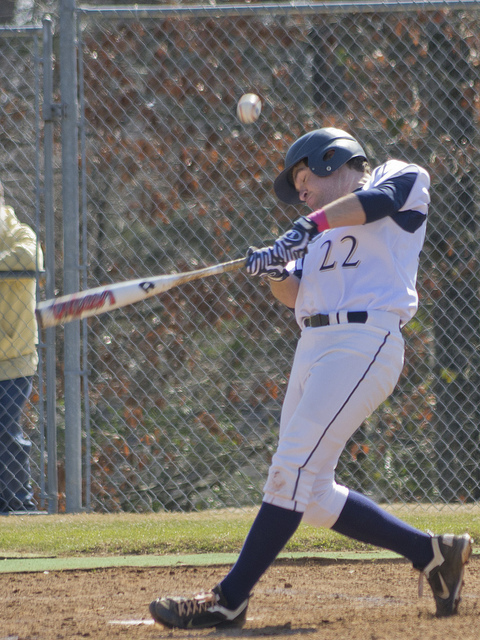

In [30]:
image = new_image
#real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate_my_greedy(image)
print(f"Model predicted caption =\n{result}")
PIL.Image.open(new_image)

# Generate predicted captions using saved model

## For the 5k images to score via Bleu

### verfiy the image and its encoding exists

In [31]:
imgs_for_bleu_scoring[:3]

['000000491856.jpg', '000000491857.jpg', '000000491872.jpg']

In [32]:
## should be 5k images
len(imgs_for_bleu_scoring)

5000

In [33]:
IMGS_DIR_FOR_BLEU

'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/'

In [34]:
os.path.exists(IMGS_DIR_FOR_BLEU + imgs_for_bleu_scoring[0])

True

In [35]:
IMGS_ENCODING_DIR_FOR_BLEU

'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/'

In [36]:
os.path.exists(IMGS_ENCODING_DIR_FOR_BLEU + imgs_for_bleu_scoring[0])

True

# ONCE , then pickled it
## Generate the predicted captions 
## Save to dict with key as img name

In [37]:
## add dir to the path
for i in range(len(imgs_for_bleu_scoring)):
    only_img = imgs_for_bleu_scoring[i]
    imgs_for_bleu_scoring[i] = IMGS_DIR_FOR_BLEU + only_img

imgs_for_bleu_scoring[:3]

['/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000491856.jpg',
 '/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000491857.jpg',
 '/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000491872.jpg']

In [38]:
os.path.basename(imgs_for_bleu_scoring[0]).split(r'.')[0]

'000000491856'

In [39]:
## dict to be built as:
#{ 'img_1_without_extn': 'predicted caption' }

comparison_dict = dict()

In [40]:
abc = ['a', 'baseball', 'player', 'swings', 'a', 'bat', 'at', 'a', 'ball', '<end>']
if type(abc) == type(list()):
    if abc[-1] == '<end>':
        abc = abc[:-1]
        abc = ' '.join(abc)
abc

'a baseball player swings a bat at a ball'

In [41]:
stat_freq = 100 ## printing status freq
count_imgs_to_process = len(imgs_for_bleu_scoring)

start_timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
start_tick = time.time()
print(f"\n\nStarted at = {start_timestamp}\n")

for idx, each_jpg in enumerate(imgs_for_bleu_scoring):
    if idx % stat_freq == 0:
        print(f"Processing {idx+1} of {count_imgs_to_process}")
    result, attention_plot = evaluate_my_greedy(each_jpg)
    
    ## convert result to string without the end seq token
    if result[-1] == '<end>':
        result = result[:-1]
    result = ' '.join(result)
    key = os.path.basename(each_jpg).split(r'.')[0]
    comparison_dict[key] = result

end_tick = time.time()
end_timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(f"\n\nEnded at = {end_timestamp}\nTime taken = {end_tick - start_tick} seconds\n")
print(f"Done")



Started at = 2020-11-13 18:58:45

Processing 1 of 5000
Processing 101 of 5000
Processing 201 of 5000
Processing 301 of 5000
Processing 401 of 5000
Processing 501 of 5000
Processing 601 of 5000
Processing 701 of 5000
Processing 801 of 5000
Processing 901 of 5000
Processing 1001 of 5000
Processing 1101 of 5000
Processing 1201 of 5000
Processing 1301 of 5000
Processing 1401 of 5000
Processing 1501 of 5000
Processing 1601 of 5000
Processing 1701 of 5000
Processing 1801 of 5000
Processing 1901 of 5000
Processing 2001 of 5000
Processing 2101 of 5000
Processing 2201 of 5000
Processing 2301 of 5000
Processing 2401 of 5000
Processing 2501 of 5000
Processing 2601 of 5000
Processing 2701 of 5000
Processing 2801 of 5000
Processing 2901 of 5000
Processing 3001 of 5000
Processing 3101 of 5000
Processing 3201 of 5000
Processing 3301 of 5000
Processing 3401 of 5000
Processing 3501 of 5000
Processing 3601 of 5000
Processing 3701 of 5000
Processing 3801 of 5000
Processing 3901 of 5000
Processing 4001 

In [43]:
list(comparison_dict.items())[:5]

[('000000491856', 'a living room with a fireplace and fireplace'),
 ('000000491857',
  'a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a'),
 ('000000491872', 'a man in a bathroom with a toilet'),
 ('000000491873', 'a man standing in front of a window'),
 ('000000491879', 'a man sitting on a wooden bench')]

## pickle it - dict without GT captions

In [50]:
#OPDIR = r'/home/rohit/PyWDUbuntu/thesis/'
#COMPARISON_DICT_PICKLE_FILE = r'CompDict_ImgCapATTEND_Run4_Ep21_BleuScore_No_GT.pkl'

#if os.path.exists(OPDIR + COMPARISON_DICT_PICKLE_FILE):
#    print(f"File already exists - DID NOT PICKLE")
#else:
#    with open(OPDIR + COMPARISON_DICT_PICKLE_FILE, 'wb') as handle:
#        pickle.dump(comparison_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
#    print(f"Success, pickled to:\n{OPDIR + COMPARISON_DICT_PICKLE_FILE}")

Success, pickled to:
/home/rohit/PyWDUbuntu/thesis/CompDict_ImgCapATTEND_Run4_Ep21_BleuScore_No_GT.pkl


# reload from pickle file - dict without GT captions

In [2]:
OPDIR = r'/home/rohit/PyWDUbuntu/thesis/'
COMPARISON_DICT_PICKLE_FILE = r'CompDict_ImgCapATTEND_Run4_Ep21_BleuScore_No_GT.pkl'

with open(OPDIR + COMPARISON_DICT_PICKLE_FILE, 'rb') as handle:
    comparison_dict_reload = pickle.load(handle)
print(f"Reloaded from picle file:\n{OPDIR + COMPARISON_DICT_PICKLE_FILE}")

Reloaded from picle file:
/home/rohit/PyWDUbuntu/thesis/CompDict_ImgCapATTEND_Run4_Ep21_BleuScore_No_GT.pkl


## insert ground truth captions from coco 2017 annotations file

In [3]:
## current dict structure:
#{ 'img_1_without_extn': 'predicted caption' #}

list(comparison_dict_reload.items())[:2]

[('000000491856', 'a living room with a fireplace and fireplace'),
 ('000000491857',
  'a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a')]

In [4]:
## new dict structure to be built as:
#{
#    'img_1_without_extn': [
#        'predicted caption',
#        [
#            'gt cap 1 from anno file',
#            'gt cap 2 from anno file',
#            'etc'
#        ]
#    ]
#}

comparison_dict_with_GT = copy.deepcopy(comparison_dict_reload)

list(comparison_dict_with_GT.items())[:2]

[('000000491856', 'a living room with a fireplace and fireplace'),
 ('000000491857',
  'a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a')]

In [5]:
for k, v in comparison_dict_with_GT.items():
    comparison_dict_with_GT[k] = [v, []] ## GT captions to into inner list

list(comparison_dict_with_GT.items())[:2]

[('000000491856', ['a living room with a fireplace and fireplace', []]),
 ('000000491857',
  ['a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a',
   []])]

In [6]:
## Annotations location
IPDIR_ANNO = r'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/coco_annotations_trainval2017/'
os.listdir(IPDIR_ANNO)

['captions_train2017 - Copy.json',
 'captions_train2017.json',
 'captions_val2017 - Copy.json',
 'captions_val2017.json',
 'sample_data_in_file.txt']

In [7]:
with open(IPDIR_ANNO+'captions_train2017.json', 'r') as f:
    annotations = json.load(f)

In [8]:
## Group all captions together having the same image ID.
## use key as 0 pre-padded image ID
## value is the captions from the file

image_path_to_caption = collections.defaultdict(list)
for value in annotations['annotations']:
    caption = value['caption'].lower()
    k = f"{value['image_id']:012d}"
    image_path_to_caption[k].append(caption)

list(image_path_to_caption.items())[:2]

[('000000203564',
  ['a bicycle replica with a clock as the front wheel.',
   'the bike has a clock as a tire.',
   'a black metal bicycle with a clock inside the front wheel.',
   'a bicycle figurine in which the front wheel is replaced with a clock\n',
   'a clock with the appearance of the wheel of a bicycle ']),
 ('000000322141',
  ['a room with blue walls and a white sink and door.',
   'blue and white color scheme in a small bathroom.',
   'this is a blue and white bathroom with a wall sink and a lifesaver on the wall.',
   'a blue boat themed bathroom with a life preserver on the wall',
   'a bathroom with walls that are painted baby blue.'])]

In [9]:
i = 0
for k in comparison_dict_with_GT.keys():
    i += 1
    if i > 2:
        break
    print(comparison_dict_with_GT[k])

['a living room with a fireplace and fireplace', []]
['a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a', []]


In [10]:
count_hits = 0
for k in comparison_dict_with_GT.keys():
    if image_path_to_caption.get(k) is not None:
        count_hits += 1
        comparison_dict_with_GT[k][1] = image_path_to_caption.get(k)
print(f"Check value if 5000\ncount_hits = {count_hits}")

Check value if 5000
count_hits = 5000


In [11]:
i = 0
for k in comparison_dict_with_GT.keys():
    i += 1
    if i > 2:
        break
    print(comparison_dict_with_GT[k])

['a living room with a fireplace and fireplace', ['a living room with a fire place and lots of furniture.', 'a living area with a fireplace and television', 'a picture of a living room with a tv over a fireplace.', 'a room features a flat screen tv, a fireplace, and knick knacks.', 'this living room has a fire place and a tv on the wall']]
['a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a', ['a group of boats floating down a river in a city.', 'many people move through water on small boats.', 'the floating market with  many shallow canoes and woman paddlers.', 'a waterway with many people on some small boats.', 'a body of water that has a lot of people in small boats.']]


## pickle it - dict WITH GT captions

In [13]:
# OPDIR = r'/home/rohit/PyWDUbuntu/thesis/'

# COMPARISON_DICT_WITH_GT_PICKLE_FILE = r'CompDict_ImgCapATTEND_Run4_Ep21_BleuScore_With_GT.pkl'

# if os.path.exists(OPDIR + COMPARISON_DICT_WITH_GT_PICKLE_FILE):
#     print(f"File already exists - DID NOT PICKLE")
# else:
#    with open(OPDIR + COMPARISON_DICT_WITH_GT_PICKLE_FILE, 'wb') as handle:
#        pickle.dump(comparison_dict_with_GT, handle, protocol=pickle.HIGHEST_PROTOCOL)
#    print(f"Success, pickled to:\n{OPDIR + COMPARISON_DICT_WITH_GT_PICKLE_FILE}")

Success, pickled to:
/home/rohit/PyWDUbuntu/thesis/CompDict_ImgCapATTEND_Run4_Ep21_BleuScore_With_GT.pkl


# CALCULATE BLEU SCORE USING NLTK¶
## SUPER IMPORTANT - CHANGE CONDA ENV FIRST

## CHANGE TO ce6idelements1

## reload from pickle file - dict WITH GT captions

In [5]:
import nltk.translate.bleu_score as nltk_bleu
import pickle
import pandas as pd
import numpy as np
import os

In [6]:
OPDIR = r'/home/rohit/PyWDUbuntu/thesis/'

In [7]:
COMPARISON_DICT_WITH_GT_PICKLE_FILE = r'CompDict_ImgCapATTEND_Run4_Ep21_BleuScore_With_GT.pkl'

In [9]:
with open(OPDIR + COMPARISON_DICT_WITH_GT_PICKLE_FILE, 'rb') as handle:
    comparison_dict_with_GT_reload = pickle.load(handle)
print(f"Reloaded from picle file:\n{OPDIR + COMPARISON_DICT_WITH_GT_PICKLE_FILE}")

Reloaded from picle file:
/home/rohit/PyWDUbuntu/thesis/CompDict_ImgCapATTEND_Run4_Ep21_BleuScore_With_GT.pkl


## Bleu scores with NLTK

### Link: https://ariepratama.github.io/Introduction-to-BLEU-in-python/

In [11]:
## see a few random entries

#dict structure is as required by nltk bleu scorer
#{
#    'img_1_without_extn': [
#        'predicted caption',
#        [
#            'gt cap 1 from anno file',
#            'gt cap 2 from anno file',
#            'etc'
#        ]
#    ]
#}


dict(list(comparison_dict_with_GT_reload.items())[10:12])

{'000000491902': ['a group of people sitting on a sidewalk',
  ['several people are seen sitting around and smoking.',
   'a coupe of people are sitting outside on a bench',
   'a man walking down the street with a cane while others sit on a bench.',
   'a group of people that are smoking on a bench',
   'a brick ally way with an old wooden bench with people sitting and smoking on it.  ']],
 '000000491904': ['a dog on a surfboard in the water',
  ['a dog jumps into a dirty pond of water.',
   'a dog takes the plunge so that he can cool off.',
   'a big black and white dog jumping into the water.',
   'a black and white dog preparing to jump in water.',
   'a dog leaping into some muddy looking water.']]}

In [12]:
## see a few random bleu scores
i = 0
for k, v in comparison_dict_with_GT_reload.items():
    i += 1
    #print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))
    print(f"Caption {i} :: {k + '.jpg'} :: Bleu score = {nltk_bleu.sentence_bleu(v[1], v[0])}")
    if i > 3:
        break

Caption 1 :: 000000491856.jpg :: Bleu score = 0.8387183577439503
Caption 2 :: 000000491857.jpg :: Bleu score = 0.07547595285839621
Caption 3 :: 000000491872.jpg :: Bleu score = 0.6288983593763685
Caption 4 :: 000000491873.jpg :: Bleu score = 0.5900468726392808


In [13]:
## calculate bleu scores for all the 5k images
bscores_all = list()
i = 0
for k, v in comparison_dict_with_GT_reload.items():
    bscore = nltk_bleu.sentence_bleu(v[1], v[0])
    bscores_all.append([k, v[0], bscore])
    i += 1
print(f"Processed {i} inputs")

/home/rohit/anaconda3/envs/ce6idelements1/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/rohit/anaconda3/envs/ce6idelements1/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Processed 5000 inputs


In [15]:
len(bscores_all)

5000

In [17]:
## see a few random entries
bscores_all[:10]

[['000000491856',
  'a living room with a fireplace and fireplace',
  0.8387183577439503],
 ['000000491857',
  'a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a man and a',
  0.07547595285839621],
 ['000000491872', 'a man in a bathroom with a toilet', 0.6288983593763685],
 ['000000491873', 'a man standing in front of a window', 0.5900468726392808],
 ['000000491879', 'a man sitting on a wooden bench', 0.6437236170541701],
 ['000000491881',
  'a red and white truck is towing a red and red bus',
  0.4724596121088535],
 ['000000491883',
  'a plate with a croissant make a bite out of a plate',
  0.3665647577471542],
 ['000000491888', 'a table set for a bite of them', 0.5553740091106136],
 ['000000491899', 'a hot dog with a hot dogs', 0.38826491325540596],
 ['000000491900',
  'a baseball player swinging a bat at a ball',
  0.9676991838227796]]

In [18]:
dfbs = pd.DataFrame(bscores_all, columns=['img', 'infcap', 'bsnltk'])
dfbs.sort_values(by=['bsnltk'], inplace = True)

In [19]:
dfbs.head()

,img,infcap,bsnltk
2021,000000501814,a formal class,1.994867e-155
3527,000000509483,a man and a man and a man and a man and a man ...,1.045693e-78
1598,000000499636,a chair and chair and chair,2.769365e-78
447,000000494003,a vase with a <unk> <unk>,3.134553e-78
3644,000000510059,a dog with a dog on a wooden surface,4.378843e-78


In [20]:
dfbs.tail()

,img,infcap,bsnltk
1453,000000498988,a black cat is sitting on top of a laptop,1.0
598,000000494711,a baseball player is swinging a bat at a ball,1.0
3589,000000509749,a man riding a surfboard in the water,1.0
3867,000000511121,a man jumping in the air to catch a frisbee,1.0
3418,000000508878,a little boy standing in front of a refrigerator,1.0


In [21]:
bs_max = float(dfbs[['bsnltk']].max(axis=0))
bs_med = float(dfbs[['bsnltk']].median(axis=0))
bs_min = float(dfbs[['bsnltk']].min(axis=0))
bs_avg = float(dfbs[['bsnltk']].mean(axis=0))
bs_std = float(dfbs[['bsnltk']].std(axis=0))
print(f"\t\tBlue Scores:")
print(f"\nMax = {bs_max}\nMedian = {bs_med}\nMin = {bs_min}\nAverage = {bs_avg}\nStd Dev = {bs_std}")

		Blue Scores:

Max = 1.0
Median = 0.6110768132237829
Min = 1.994867213945039e-155
Average = 0.6000056733940884
Std Dev = 0.18002708995122926


In [43]:
len(dfbs)

5000

In [22]:
len(dfbs[dfbs['bsnltk'] > 0.95])

73

# USING THIS BETTER way

In [44]:
## freq distribution - with interval size = 0.10
total_data = len(dfbs)
step = 0.1
prev_running = 0
for val in np.arange(step, 1.0 + step, step):   ## do not want to start from value 0.0 but from 0.1 till 1.0
    wintop = (int(val * 100))/100
    winbot = wintop-step
    print(f"{winbot:.2f} to {wintop:.2f} : ", end='')
    cnt_running = len(dfbs[ dfbs['bsnltk'] < wintop ] )
    cnt_this_window = cnt_running - prev_running
    print(f"cnt= {cnt_this_window: <6} ", end='')
    print(f"cntCum= {cnt_running: <7}", end='')
    print(f"relFreq= {cnt_this_window/total_data: <7.2f}", end='')
    print(f"cumFreq= {cnt_running/total_data: <7.2f}")
    prev_running = cnt_running

0.00 to 0.10 : cnt= 35     cntCum= 35     relFreq= 0.01   cumFreq= 0.01   
0.10 to 0.20 : cnt= 94     cntCum= 129    relFreq= 0.02   cumFreq= 0.03   
0.20 to 0.30 : cnt= 154    cntCum= 283    relFreq= 0.03   cumFreq= 0.06   
0.30 to 0.40 : cnt= 381    cntCum= 664    relFreq= 0.08   cumFreq= 0.13   
0.40 to 0.50 : cnt= 724    cntCum= 1388   relFreq= 0.14   cumFreq= 0.28   
0.50 to 0.60 : cnt= 997    cntCum= 2385   relFreq= 0.20   cumFreq= 0.48   
0.60 to 0.70 : cnt= 1099   cntCum= 3484   relFreq= 0.22   cumFreq= 0.70   
0.70 to 0.80 : cnt= 867    cntCum= 4351   relFreq= 0.17   cumFreq= 0.87   
0.80 to 0.90 : cnt= 468    cntCum= 4819   relFreq= 0.09   cumFreq= 0.96   
0.90 to 1.00 : cnt= 167    cntCum= 4986   relFreq= 0.03   cumFreq= 1.00   


# Older way - DO NOT USE

In [23]:
## freq distribution - with interval size = 0.05
total_data = len(dfbs)
step = np.linspace(0,1,21)[1] - np.linspace(0,1,21)[0]
prev_running = 0
for val in np.linspace(0,1,21)[1:]:   ## do not want to start from value 0.0 but from 0.05 till 1.0
    wintop = round(float(val), 2)
    winbot = wintop-step
    print(f"{winbot:.2f} to {wintop:.2f} : ", end='')
    cnt_running = len(dfbs[ dfbs['bsnltk'] < wintop ] )
    cnt_this_window = cnt_running - prev_running
    print(f"cnt= {cnt_this_window: <6} ", end='')
    print(f"cntCum= {cnt_running: <7}", end='')
    print(f"relFreq= {cnt_this_window/total_data: <7.2f}", end='')
    print(f"cumFreq= {cnt_running/total_data: <7.2f}")
    prev_running = cnt_running

0.00 to 0.05 : cnt= 16     cntCum= 16     relFreq= 0.00   cumFreq= 0.00   
0.05 to 0.10 : cnt= 19     cntCum= 35     relFreq= 0.00   cumFreq= 0.01   
0.10 to 0.15 : cnt= 37     cntCum= 72     relFreq= 0.01   cumFreq= 0.01   
0.15 to 0.20 : cnt= 57     cntCum= 129    relFreq= 0.01   cumFreq= 0.03   
0.20 to 0.25 : cnt= 65     cntCum= 194    relFreq= 0.01   cumFreq= 0.04   
0.25 to 0.30 : cnt= 89     cntCum= 283    relFreq= 0.02   cumFreq= 0.06   
0.30 to 0.35 : cnt= 126    cntCum= 409    relFreq= 0.03   cumFreq= 0.08   
0.35 to 0.40 : cnt= 255    cntCum= 664    relFreq= 0.05   cumFreq= 0.13   
0.40 to 0.45 : cnt= 314    cntCum= 978    relFreq= 0.06   cumFreq= 0.20   
0.45 to 0.50 : cnt= 410    cntCum= 1388   relFreq= 0.08   cumFreq= 0.28   
0.50 to 0.55 : cnt= 481    cntCum= 1869   relFreq= 0.10   cumFreq= 0.37   
0.55 to 0.60 : cnt= 516    cntCum= 2385   relFreq= 0.10   cumFreq= 0.48   
0.60 to 0.65 : cnt= 529    cntCum= 2914   relFreq= 0.11   cumFreq= 0.58   
0.65 to 0.70 : cnt= 570  

In [39]:
step = 0.1
for v in np.arange(step, 1.0, step):
    print(v)
    print( (int(v * 100))/100 )
    print("")

0.1
0.1

0.2
0.2

0.30000000000000004
0.3

0.4
0.4

0.5
0.5

0.6
0.6

0.7000000000000001
0.7

0.8
0.8

0.9
0.9



In [25]:
np.linspace(0,1,21)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [26]:
np.linspace(0,1,21)[4:]

array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [24]:
step = np.linspace(0,1,21)[1] - np.linspace(0,1,21)[0]
step

0.05

In [27]:
np.linspace(0,1,11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [28]:
np.linspace(0,1,11)[4:]

array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [29]:
step = np.linspace(0,1,11)[1] - np.linspace(0,1,11)[0]
step

0.1